In [15]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean


# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy

import matplotlib.pyplot as plt


In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'
model_nam = 'inset_oneto_denier'

base_model_ws = join(loadpth,model_nam)
all_model_ws = join(loadpth, 'parallel_oneto_denier')

m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [12]:
m_ver = ''

In [5]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [116]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]
    
# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color.geology = gel_color.geology.str.lower()
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')

In [7]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
dates_stps = strt_date + (np.repeat(stplen, m.dis.nstp.array).cumsum()*24).astype('timedelta64[h]')

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper

# Obs checking

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

# hob metadata
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))


In [9]:
def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)

In [199]:
# 
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'], dtype=np.float64)
mw_stats = pd.DataFrame(columns=['realization','SOSE','RMSE','NSE'], dtype=np.float64)
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    hobout = clean_hob(model_ws)
    # summary stats by well
    mw_stats['realization'] = t
    for s in hobout.Sensor.unique():
        df_s = hobout[hobout.Sensor==s]
        mw_stats.loc[s,'SOSE'] = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
        mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
        mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
        mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

    # summary statistics
    sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
    sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
    sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)


<AxesSubplot: >

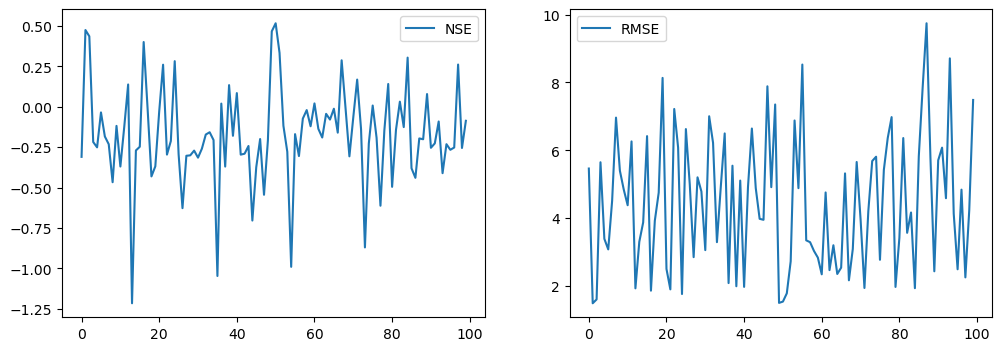

In [200]:
# review to see if error is generally similar between realizations
# review hydrographs for realization with worst error
fig,ax = plt.subplots(1,2, figsize=(12,4))
sum_stats.plot(y='NSE', ax=ax[0])
sum_stats.plot(y='RMSE', ax=ax[1])


In [215]:
sum_stats.loc[89]

r2     -0.406323
RMSE    2.427809
NSE     0.078278
Name: 89, dtype: float64

In [211]:
# check hydrographs with worst error
t = sum_stats['RMSE'].idxmax()
# t = sum_stats['RMSE'].idxmin()
# t = 45
print(t)
hobout = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe')
# hob_long

87


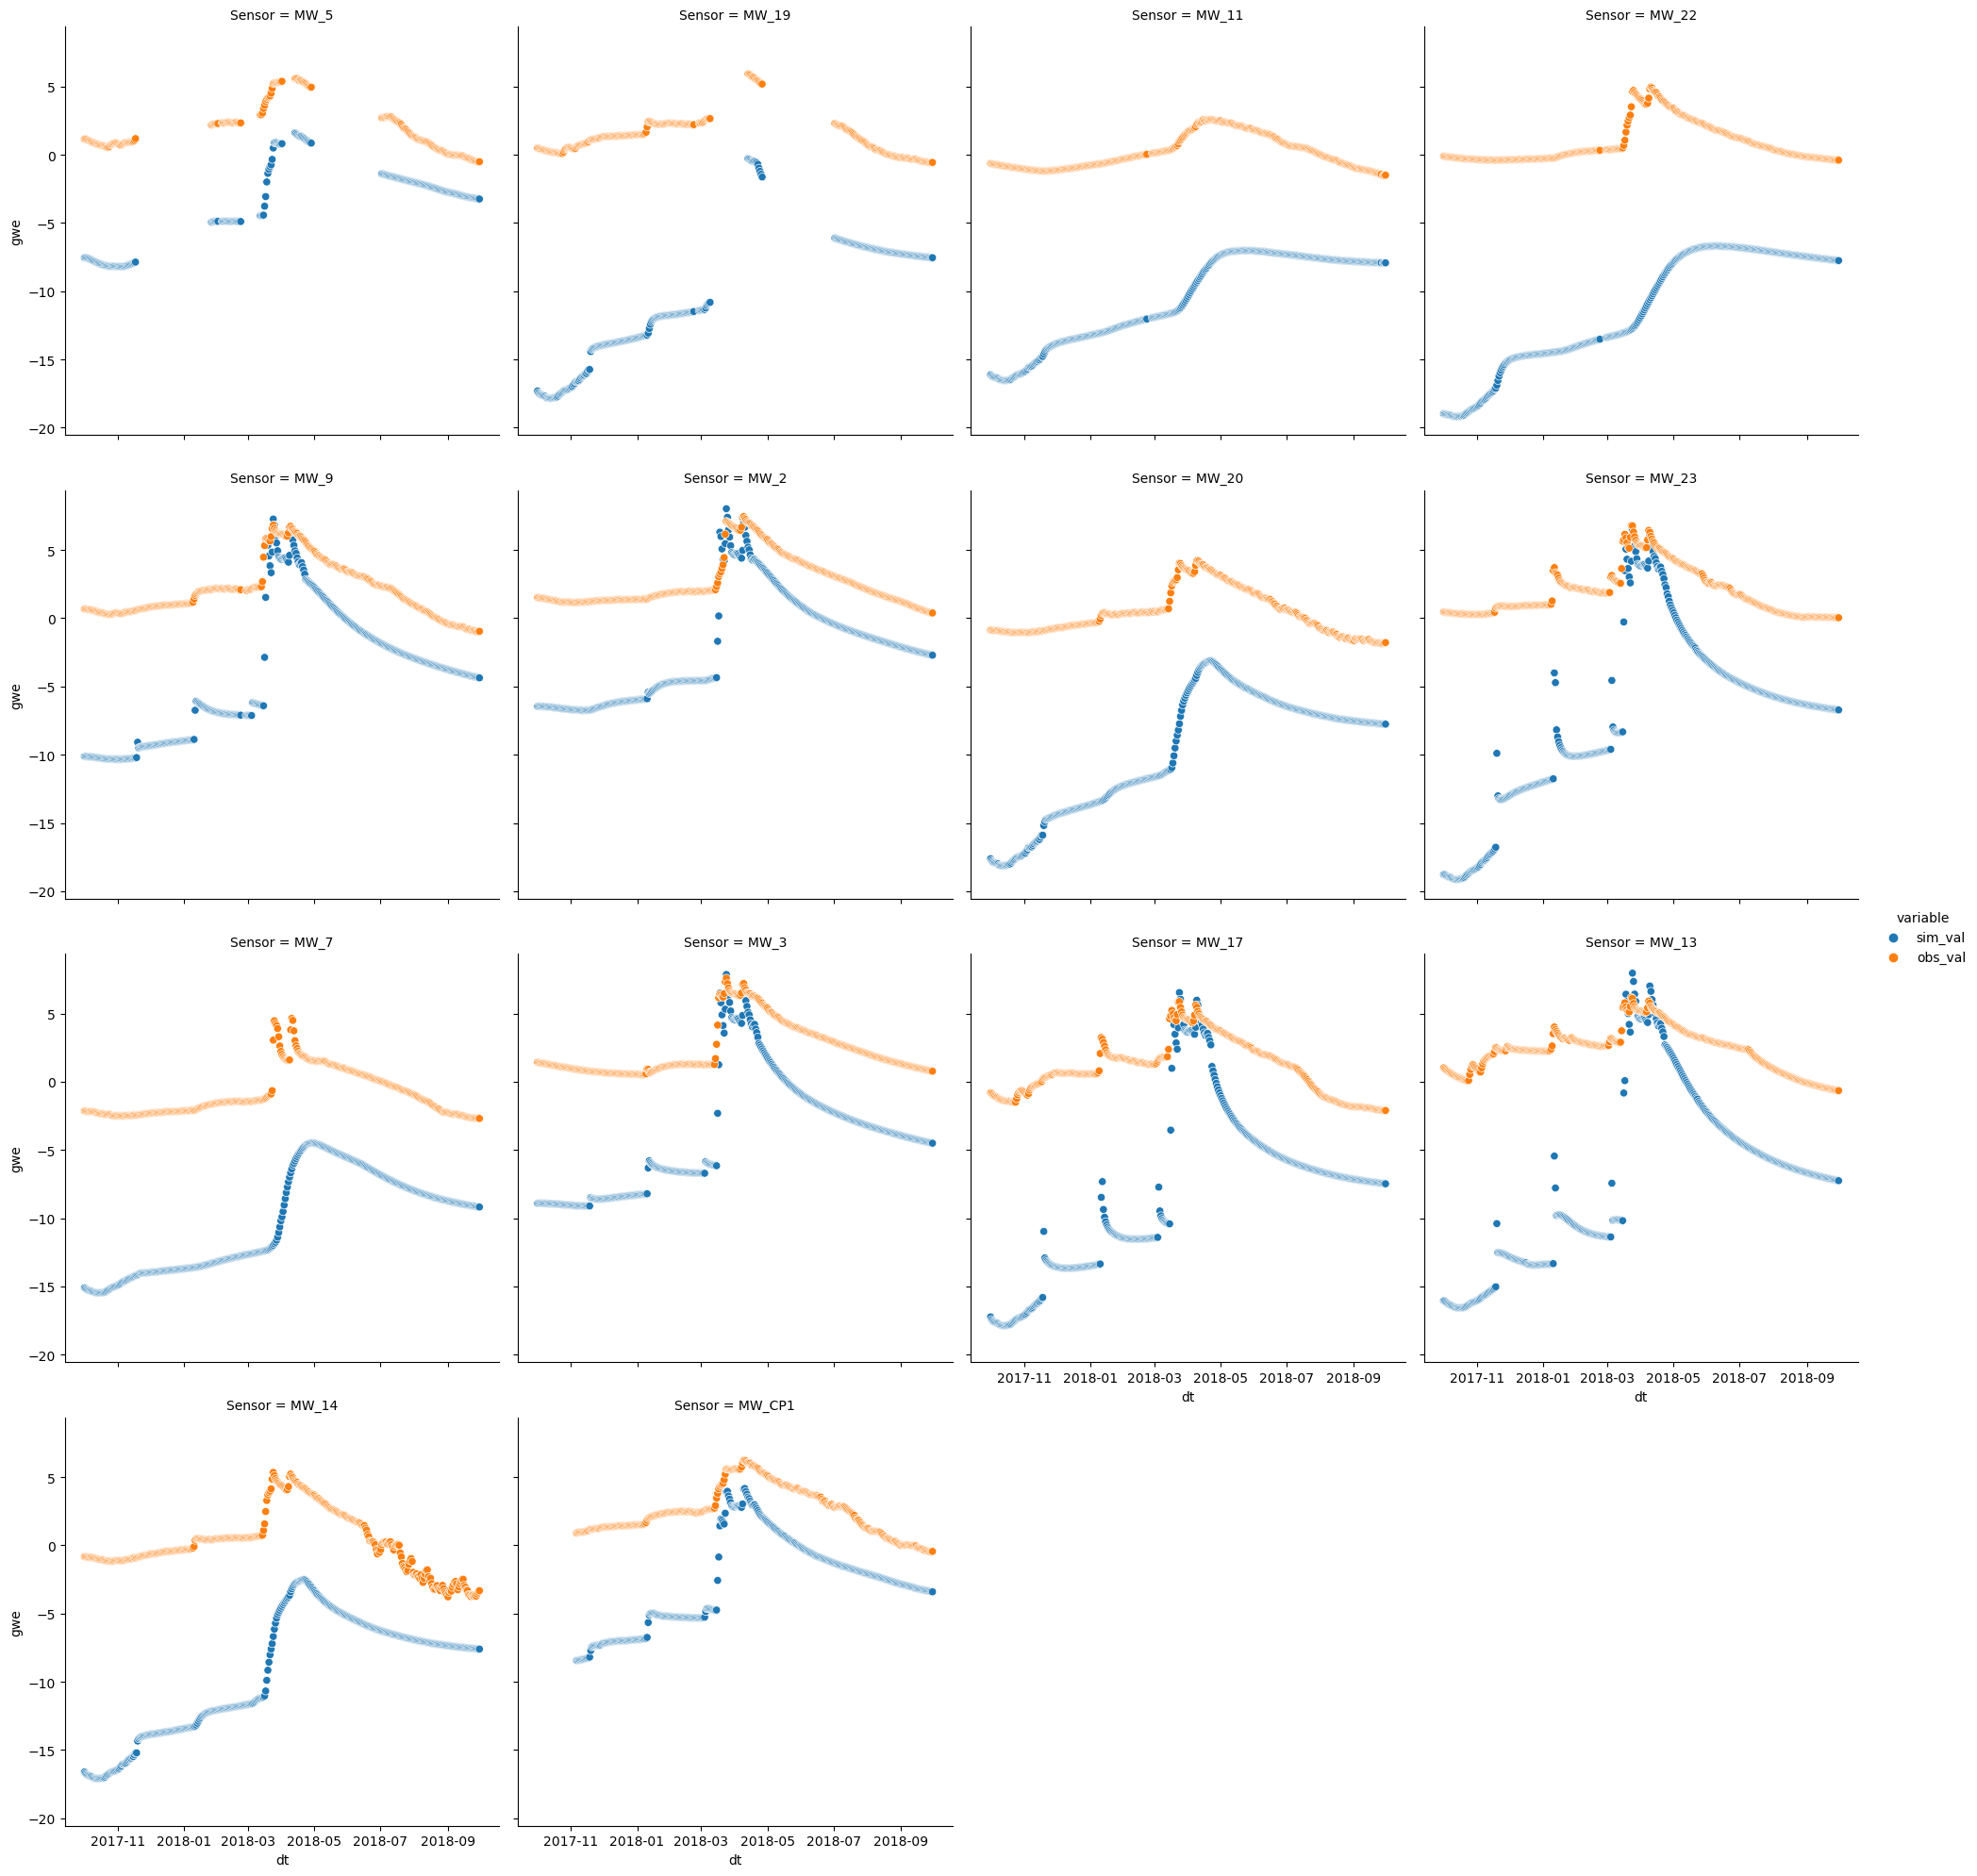

In [212]:
# in the wrost case the dynamics match but the magnitude is off (levels start much too low)
import seaborn as sns
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='variable', col_wrap=4)



# Stream seepage plots

In [117]:
pd_sfr = grid_sfr.set_index(['i','j'])[['rchlen','strtop', 'facies', 'color']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    sfrdf[['row','column']]-=1 # convert to python
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmd2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmd2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmd2cfs
    
    # create different column for stream losing vs gaining seeapge
    sfrdf_plot['Qrech'] = np.where(sfrdf_plot.Qaquifer>0, sfrdf_plot.Qaquifer,0)
    sfrdf_plot['Qbase'] = np.where(sfrdf_plot.Qaquifer<0, sfrdf_plot.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf_plot['gaining'] = (sfrdf_plot.gradient == 0)
    sfrdf_plot['losing'] = (sfrdf_plot.gradient >= 0)
    sfrdf_plot['connected'] = (sfrdf_plot.gradient < 1)
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [118]:
sfrdf =  clean_sfr_df(base_model_ws)

In [ ]:
# far and beyond the stream system is losing which aligns with historic data where gw is above thalweg but never above the
# flood stage

# sfr_sum = sfrdf.groupby('dt').sum(numeric_only=True)

In [110]:
# grid_sfr[['iseg','ireach','facies']]
# sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)


In [205]:
out_files = pd.DataFrame(glob.glob(all_model_ws+'/*/*.sfr.out'))
# out_files
# out_num = out_files[0].str.extract(r'(\d{3})').astype(int)
# out_num[0].values

## Gradient plots (spatial)
1. Seepage averaged across the year (or between dry and wet season) and the rows could be realizations instead which would help indicate consistency across realizations  
2. Heat map of columns with stream segments, rows of dates and the color blue to red for gaining or losing with the seepage averaged across all realizations

When the gradient is greater than 1 we know we have disconnected conditions, I need to represent the count of days where the system is connected.

In [33]:
t0 = time.time()
# fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

for t in np.arange(0,1):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
    sfrdf =  clean_sfr_df(model_ws)
    sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
#     sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
#     sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)

#     for n,f in enumerate(['mud','sandy mud','sand','gravel']):
#         ax_n = ax[int(n/2), n%2]
#         df_plt = sfr_facies_sum[sfr_facies_sum.variable=='Qrech'].filter(like=f, axis=0).reset_index('facies')
#         df_plt.cumsum().plot(y='value', ax=ax_n, legend=False, color='gray')
#         ax_n.set_title(f)
#         ax_n.set_yscale('log')
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

Time: 0.07 min


In [120]:
sfrdf.facies.unique()
# grid_sfr.facies.unique()
sfrdf.facies[-1] # sand is failing

'sand'

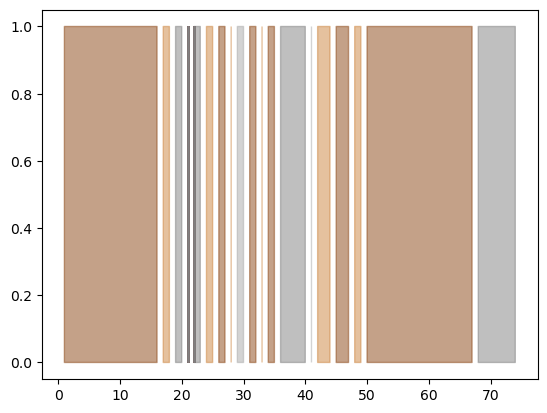

In [148]:
# grid_sfr.plot(x='iseg',y='facies', kind='bar')
# plt.fill(x= sfrdf.segment, y=1) #, color = sfrdf.color.values)
# sfrdf.head(20)
fig,ax = plt.subplots()
for f in sfrdf.facies.unique():
    ax.fill_between(sfrdf.segment, 0, 1, where = sfrdf.facies==f,
                    color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)#transform=ax.get_xaxis_transform())

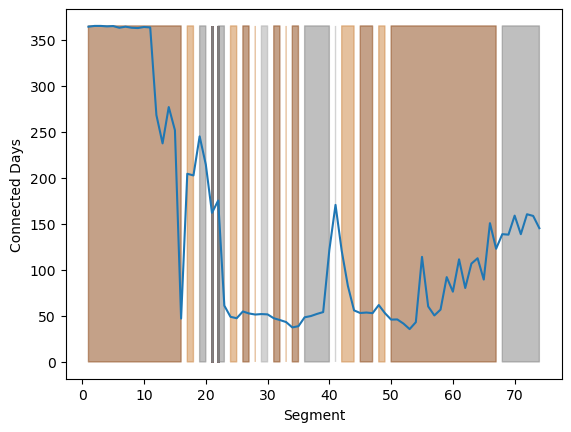

In [149]:
fig,ax = plt.subplots()

# days connected
df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']].multiply(1/6)
df_plt.plot(legend=False, ax=ax)
plt.ylabel('Connected Days')
plt.xlabel('Segment')

for f in sfrdf.facies.unique():
    ax.fill_between(sfrdf.segment, 0, df_plt.max(), where = sfrdf.facies==f,
                    color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_196636\2254996299.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sfr_facies.groupby('segment').mean()['gradient'].plot()


<AxesSubplot: xlabel='segment'>

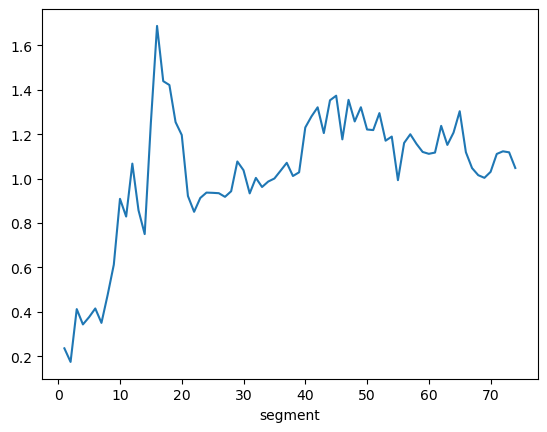

In [27]:
# value of heat map vs line plot
# sfr_facies.groupby('segment').sum()['Qaquifer'].plot()
sfr_facies.groupby('segment').mean()['gradient'].plot()

## Notes
In these I need to clarify the proportion of the streambed (length or area) that is each facies to show that despite being only a small percent of the streambed sand and gravel make up a significant portion of recharge and baseflow. 

## Seepage plots (temporal)
Aggregate by facies to plot cumulative seepage (by time) to help show variability caused by geology.

Time: 10.27 min


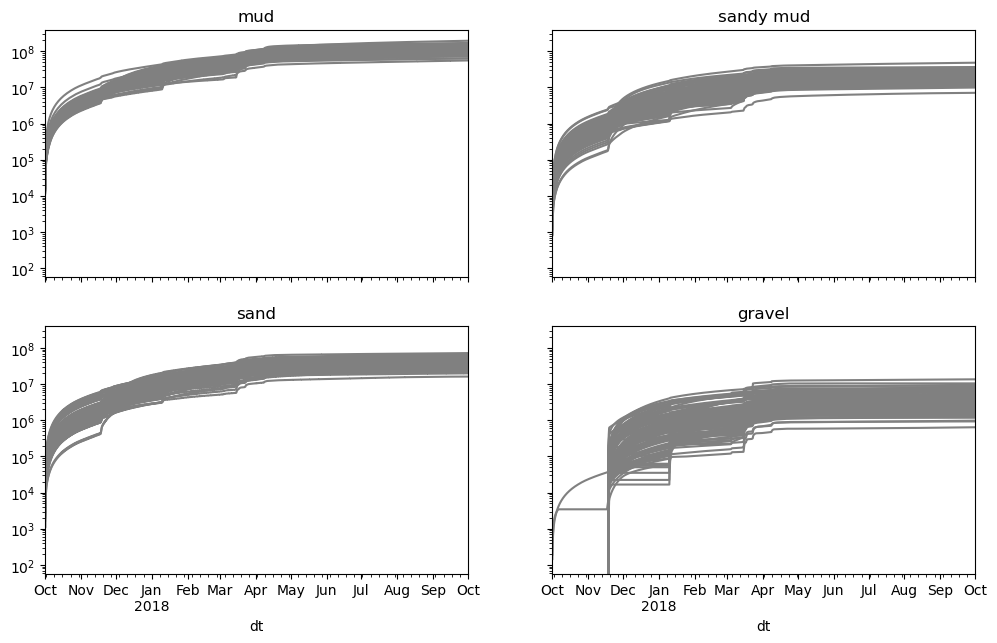

In [206]:
t0 = time.time()
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
    sfrdf =  clean_sfr_df(model_ws)
    sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
    sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
    sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)

    for n,f in enumerate(['mud','sandy mud','sand','gravel']):
        ax_n = ax[int(n/2), n%2]
        df_plt = sfr_facies_sum[sfr_facies_sum.variable=='Qrech'].filter(like=f, axis=0).reset_index('facies')
        df_plt.cumsum().plot(y='value', ax=ax_n, legend=False, color='gray')
        ax_n.set_title(f)
        ax_n.set_yscale('log')
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

Despite being only a small percentage of the stream segments, the sand and gravel produce a significant portion of the stream seepage.

Time: 8.16 min


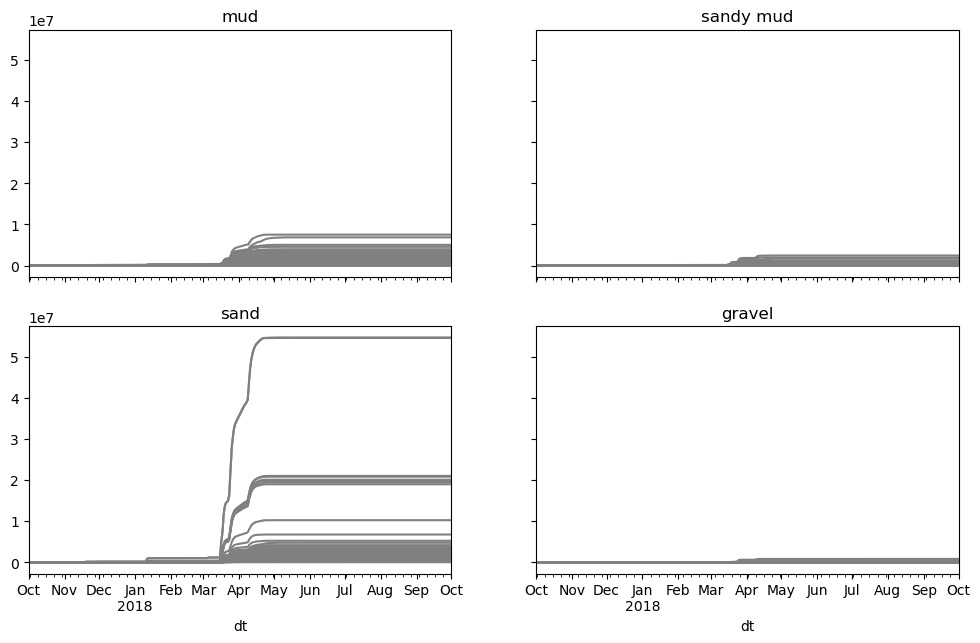

In [207]:
t0 = time.time()
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
    sfrdf =  clean_sfr_df(model_ws)
    sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
    sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
    sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)

    for n,f in enumerate(['mud','sandy mud','sand','gravel']):
        ax_n = ax[int(n/2), n%2]
        df_plt = sfr_facies_sum[sfr_facies_sum.variable=='Qbase'].filter(like=f, axis=0).reset_index('facies')
        df_plt.cumsum().plot(y='value', ax=ax_n, legend=False, color='gray')
        ax_n.set_title(f)
#         ax_n.set_yscale('log')
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

## Streamflow
No need to aggregate by facies, instead show impact at downstream end in terms of time step and cumulative

Time: 6.34 min


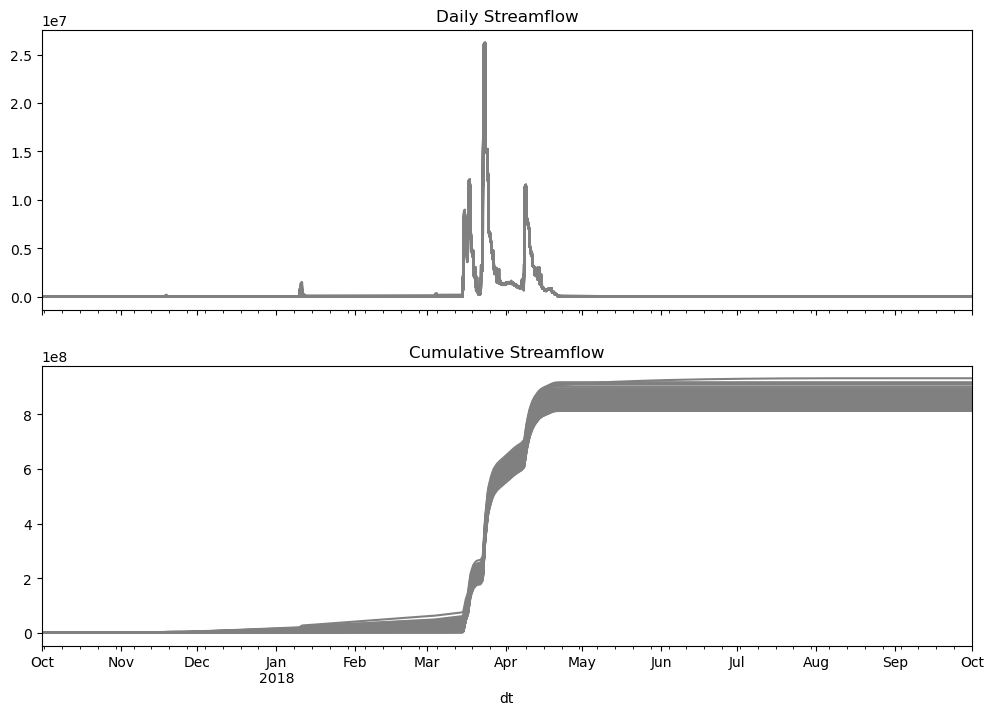

In [208]:
t0 = time.time()
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True, sharey=False)#

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
    sfrdf =  clean_sfr_df(model_ws)
    # plot from last segment (shows cumulative effects)
    sfr_last = sfrdf[sfrdf.segment==sfrdf.segment.max()]
    sfr_last.plot(y='Qin', ax=ax[0], legend=False, color='gray')
    ax[0].set_title('Daily Streamflow')
    sfr_last.cumsum().plot(y='Qin', ax=ax[1], legend=False, color='gray')
    ax[1].set_title('Cumulative Streamflow')
#         ax_n.set_yscale('log')
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))